# Deep Convolutional

In [ ]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy scikit-image keras keras-tuner matplotlib kiwisolver scikit-learn tensorflow-io


In [1]:
import os
import keras_tuner as kt
from numpy import asarray
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import math
import imageio.v2 as imageio
import glob
from skimage.color import lab2rgb
import PIL
import PIL.Image


## Import all Modules and Configure GPU

In [2]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow_io as tfio

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


2022-06-15 13:48:31.497457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 13:48:31.521343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 13:48:31.521531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 13:48:31.522188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
tf.__version__


'2.9.1'

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [4]:
def load_from_directory(data_dir, train_subdir, test_subdir, image_size, batch_size, train_size=0.8):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize):
        ds = ds.cache()
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    data_train_dir = pathlib.Path(data_dir.as_posix() + "/" + train_subdir)
    image_count = len(list(data_train_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_train_dir, image_count))
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    data_test_dir = pathlib.Path(data_dir.as_posix() + "/" + test_subdir)
    image_count = len(list(data_test_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_test_dir, image_count))
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_test_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    @tf.function
    def preprocess_lab(img):
        image = tf.cast(img, tf.float32)

        lab = tfio.experimental.color.rgb_to_lab(image)
        l = lab[..., 0]

        l = tf.expand_dims(l, axis=-1)
        return tf.cast(tf.concat(l, axis=-1), tf.float32)

    @tf.function
    def preprocess_lab2(img):
        image = tf.cast(img, tf.float32)
        lab = tfio.experimental.color.rgb_to_lab(image)
        a = lab[..., 1]
        b = lab[..., 2]

        a = tf.expand_dims(a, axis=-1)
        b = tf.expand_dims(b, axis=-1)
        return tf.cast(tf.concat([a, b], axis=-1), tf.float32)

    nrBatches = image_count / batch_size

    # Translate [0,255] -> [-128, 128]
    normalized_train_ds = (train_ds.map(lambda x: preprocess_lab(normalization_layer(x))))

    # Translate [0,255] -> [-1, 1]
    normalized_test_ds = (test_ds.map(lambda x: (preprocess_lab2(normalization_layer(x)) * (1.0 / 128.0))))

    train_ds = tf.data.Dataset.zip((normalized_train_ds, normalized_test_ds))
    train_ds = train_ds.take(int(train_size * nrBatches))
    test_ds = train_ds.skip(int(train_size * nrBatches)).take(int((1.0 - train_size) * nrBatches))

    return configure_for_performance(train_ds, AUTOTUNE, 0), configure_for_performance(test_ds, AUTOTUNE, 0)


In [5]:
BATCH_SIZE = 12
IMAGE_SIZE = (256, 256)
EPOCHS = 128

data_directory_path = "data-colorize/"
data_dir = pathlib.Path(data_directory_path)

train_images, test_images = load_from_directory(data_dir, "", "", IMAGE_SIZE, BATCH_SIZE, 0.85)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))


data-colorize: Found 92219 files
Found 92219 files belonging to 1 classes.


2022-06-15 13:48:41.513697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-15 13:48:41.514632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 13:48:41.514814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 13:48:41.514916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

data-colorize: Found 92219 files
Found 92219 files belonging to 1 classes.
Number of batches 6532 of 12 elements


2022-06-15 13:48:47.720773: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


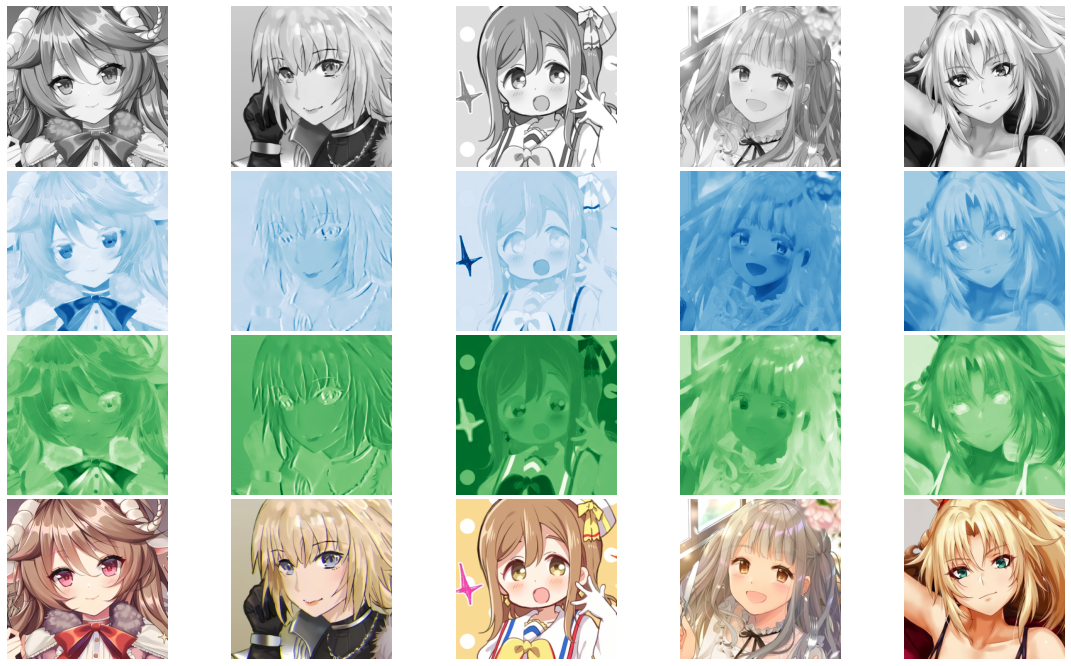

In [6]:
num_examples_to_generate = 9

nrCol = 5
plt.figure(figsize=(10 * 2, 12))
for images in train_images.take(1):
    for i in range(0, 5):

        trainImage, expectedImage = images
        # Transform pixel values from [-1,1] to [0,1]
        trainLAB = trainImage[i, :, :].numpy().astype(dtype='float32')

        ax = plt.subplot(4, nrCol, nrCol * 0 + i + 1)
        plt.imshow(trainLAB, cmap='gray')
        plt.axis("off")

        ax = plt.subplot(4, nrCol, nrCol * 1 + i + 1)
        plt.imshow(expectedImage[i, :, :, 0], cmap='Blues')
        plt.axis("off")

        ax = plt.subplot(4, nrCol, nrCol * 2 + i + 1)
        plt.imshow(expectedImage[i, :, :, 1], cmap='Greens')
        plt.axis("off")

        expectedImage = expectedImage[i, :, :, :].numpy().astype(dtype='float32') * 128
        RGBImage = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
        RGBImage[:, :, 0] = trainLAB[:, :, 0]
        RGBImage[:, :, 1:] = expectedImage

        rgbExpected = lab2rgb(RGBImage)

        ax = plt.subplot(4, nrCol, nrCol * 3 + i + 1)
        plt.imshow(rgbExpected)
        plt.axis("off")
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


## Create Model

In [7]:
def create_model(hp, input_shape):
    model = tf.keras.Sequential()

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    model.add(layers.Input(input_shape))

    number_layer_offset = hp.Int('number_layers', min_value=2, max_value=6, step=1)
    max_layers = 3

    n2 = math.log2(float(IMAGE_SIZE[0]))
    num_layers = max(int(n2) - number_layer_offset, 0)
    num_layers = max(1, min(num_layers, max_layers))

    hp_kernel_filter_size_l0 = hp.Int('kernel_filter_downscale', min_value=4, max_value=8, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (i + hp_kernel_filter_size_l0)

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

        model.add(layers.Conv2D(filters=filter_size, kernel_size=(3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))
        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', strides=2))
        model.add(layers.ReLU(dtype='float32'))
        #model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # model.add(layers.Flatten())
    hp_kernel_filter_size_latent = hp.Int('kernel_filter_latent', min_value=6, max_value=9, step=1)
    model.add(layers.Conv2D(2 ** hp_kernel_filter_size_latent, (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.ReLU(dtype='float32'))
    model.add(layers.Conv2D(2 ** (hp_kernel_filter_size_latent - 1), (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.ReLU(dtype='float32'))

    hp_kernel_filter_size_l1 = hp.Int('kernel_filter_upscale', min_value=5, max_value=9, step=1)

    #upscale_number_layer_offset = hp.Int('upscale_number_layer_offset', min_value=4, max_value=6, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

        #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))
        model.add(layers.UpSampling2D(size=(2, 2)))
        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

    model.add(layers.Conv2D(2, (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.Activation(activation='tanh', dtype='float32'))

    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])

    model.compile(optimizer=hp_optimizer,
                  loss='mse',
                  metrics=['accuracy'])

    return model


## Hyperparameter

In [8]:

image_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

def model_builder(hp):
    model = create_model(hp, image_shape)
    return model


tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=16,
                     factor=5,
                     directory='cache',
                     project_name=str.format('Colorizing - LAB - {0}', "Anime"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=5)
tuner.search(train_images.take(1000), validation_data=test_images, epochs=EPOCHS, batch_size=BATCH_SIZE,
             callbacks=[stop_early], verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)

model = tuner.hypermodel.build(best_hps)
model.summary()


INFO:tensorflow:Reloading Oracle from existing project cache/Colorizing - LAB - Anime/oracle.json
INFO:tensorflow:Reloading Tuner from cache/Colorizing - LAB - Anime/tuner0.json
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 re_lu_14 (ReLU)             (None, 256, 256, 16)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 16)      2320      
                                                                 
 re_lu_15 (ReLU)             (None, 128, 128, 16)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 32)      4640      
                                    

## Train the Model

In [9]:
def showResult(model, batchImage, maxNumImages=6):
    output = model.predict(batchImage)
    output = output * 128
    nrElements = min(len(output), maxNumImages)

    fig = plt.figure(figsize=(maxNumImages * 2, 4 * 2))
    for image in batchImage:
        for i in range(nrElements):
            trainImage, expectedImage = image

            canvas = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
            canvas[:, :, 0] = trainImage[i][:, :, 0]
            canvas[:, :, 1:] = expectedImage[i][:, :, :] * 128

            ax = plt.subplot(4, maxNumImages, i + 1)
            plt.imshow((asarray(lab2rgb(canvas)).astype(dtype='float32')))
            plt.axis("off")

            ax = plt.subplot(4, maxNumImages, maxNumImages * 1 + i + 1)
            plt.imshow(output[i, :, :, 0], cmap='Blues')
            plt.axis("off")

            ax = plt.subplot(4, maxNumImages, maxNumImages * 2 + i + 1)
            plt.imshow(output[i, :, :, 1], cmap='Greens')
            plt.axis("off")

            canvas = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
            canvas[:, :, 0] = trainImage[i][:, :, 0]
            canvas[:, :, 1:] = output[i][:, :, :]

            ax = plt.subplot(4, maxNumImages, maxNumImages * 3 + 1 + i)
            plt.imshow(asarray(lab2rgb(canvas)).astype(dtype='float32'))
            plt.axis("off")

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainData = trainData
        self.trainSet = self.trainData.take(1)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainSet)
        fig.savefig("animeColorLAB{0}.png".format(epoch))
        fig = showResult(self.model, self.trainSet, 12)
        fig.savefig("animeColorLABBig{0}.png".format(epoch))


In [10]:

checkpoint_path = "checkpoints/training_anime_coloring_lab/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()


# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

model_history = model.fit(train_images,
                          epochs=EPOCHS,
                          batch_size=1,
                          validation_data=test_images,
                          verbose=1, callbacks=[cp_callback, save_images(train_images)])

model.save_weights(checkpoint_path)


Epoch 1/128


2022-06-15 13:48:55.607962: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-06-15 13:48:56.777106: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


6532/6532 [==============================] - 649s 98ms/step - loss: 0.0134 - accuracy: 0.6659
Epoch 2/128
6532/6532 [==============================] - 356s 54ms/step - loss: 0.0129 - accuracy: 0.6858
Epoch 3/128
6532/6532 [==============================] - 327s 50ms/step - loss: 0.0128 - accuracy: 0.6889
Epoch 4/128
6532/6532 [==============================] - 311s 48ms/step - loss: 0.0128 - accuracy: 0.6897
Epoch 5/128
6532/6532 [==============================] - 367s 56ms/step - loss: 0.0127 - accuracy: 0.6904
Epoch 6/128
6532/6532 [==============================] - 274s 42ms/step - loss: 0.0127 - accuracy: 0.6908
Epoch 7/128
6532/6532 [==============================] - 218s 33ms/step - loss: 0.0127 - accuracy: 0.6909
Epoch 8/128
6532/6532 [==============================] - 218s 33ms/step - loss: 0.0127 - accuracy: 0.6909
Epoch 9/128
6532/6532 [==============================] - 248s 38ms/step - loss: 0.0126 - accuracy: 0.6914
Epoch 10/128
6532/6532 [==============================] - 

/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)


6532/6532 [==============================] - 244s 37ms/step - loss: 0.0112 - accuracy: 0.6892
Epoch 83/128
6532/6532 [==============================] - 238s 36ms/step - loss: 0.0113 - accuracy: 0.6891
Epoch 84/128
6532/6532 [==============================] - 241s 37ms/step - loss: 0.0113 - accuracy: 0.6889
Epoch 85/128
6532/6532 [==============================] - 245s 38ms/step - loss: 0.0113 - accuracy: 0.6892
Epoch 86/128
6532/6532 [==============================] - 238s 36ms/step - loss: 0.0112 - accuracy: 0.6895
Epoch 87/128
6532/6532 [==============================] - 241s 37ms/step - loss: 0.0112 - accuracy: 0.6896
Epoch 88/128
6532/6532 [==============================] - 240s 37ms/step - loss: 0.0112 - accuracy: 0.6895
Epoch 89/128
6532/6532 [==============================] - 243s 37ms/step - loss: 0.0112 - accuracy: 0.6893
Epoch 90/128
6532/6532 [==============================] - 247s 38ms/step - loss: 0.0112 - accuracy: 0.6893
Epoch 91/128
6532/6532 [==========================

/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return func(*args, **kwargs)


6532/6532 [==============================] - 205s 31ms/step - loss: 0.0111 - accuracy: 0.6892
Epoch 104/128
6532/6532 [==============================] - 205s 31ms/step - loss: 0.0111 - accuracy: 0.6895
Epoch 105/128
6532/6532 [==============================] - 205s 31ms/step - loss: 0.0111 - accuracy: 0.6891
Epoch 106/128
1/1 [==============================] - 0s 10ms/step


/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return func(*args, **kwargs)


6532/6532 [==============================] - 205s 31ms/step - loss: 0.0110 - accuracy: 0.6895
Epoch 107/128
6532/6532 [==============================] - 205s 31ms/step - loss: 0.0110 - accuracy: 0.6896
Epoch 108/128
6532/6532 [==============================] - 205s 31ms/step - loss: 0.0110 - accuracy: 0.6897
Epoch 109/128
6532/6532 [==============================] - 205s 31ms/step - loss: 0.0110 - accuracy: 0.6896
Epoch 110/128
6532/6532 [==============================] - 205s 31ms/step - loss: 0.0110 - accuracy: 0.6896
Epoch 111/128
6532/6532 [==============================] - 204s 31ms/step - loss: 0.0110 - accuracy: 0.6894
Epoch 112/128
6532/6532 [==============================] - 205s 31ms/step - loss: 0.0110 - accuracy: 0.6894
Epoch 113/128
6532/6532 [==============================] - 204s 31ms/step - loss: 0.0110 - accuracy: 0.6897
Epoch 114/128
6532/6532 [==============================] - 204s 31ms/step - loss: 0.0110 - accuracy: 0.6899
Epoch 115/128
6532/6532 [=================

/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return func(*args, **kwargs)


6532/6532 [==============================] - 213s 33ms/step - loss: 0.0109 - accuracy: 0.6894
Epoch 124/128
6532/6532 [==============================] - 211s 32ms/step - loss: 0.0109 - accuracy: 0.6896
Epoch 125/128
1/1 [==============================] - 0s 9ms/step0s - loss: 0.0109 - accuracy: 0.68


/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return func(*args, **kwargs)


6532/6532 [==============================] - 234s 36ms/step - loss: 0.0109 - accuracy: 0.6896
Epoch 126/128
6532/6532 [==============================] - 227s 35ms/step - loss: 0.0109 - accuracy: 0.6894
Epoch 127/128
6532/6532 [==============================] - 204s 31ms/step - loss: 0.0110 - accuracy: 0.6891
Epoch 128/128
6532/6532 [==============================] - 204s 31ms/step - loss: 0.0109 - accuracy: 0.6895


In [11]:
model.save("dc-anime-colorization-lab.h5")


# Result

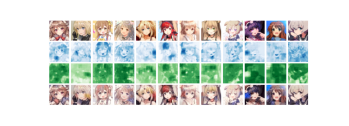

In [12]:
plt.imshow(PIL.Image.open("animeColorLABBig{0}.png".format(EPOCHS - 1)))
plt.axis("off")
plt.show()


In [13]:
anim_file = 'anime-colorizing-lab.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('animeColorLABBig*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Image(url=anim_file)


In [14]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    fig = plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    fig.show()
    fig.savefig(title + ".png")


/tmp/ipykernel_1800116/3754951874.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


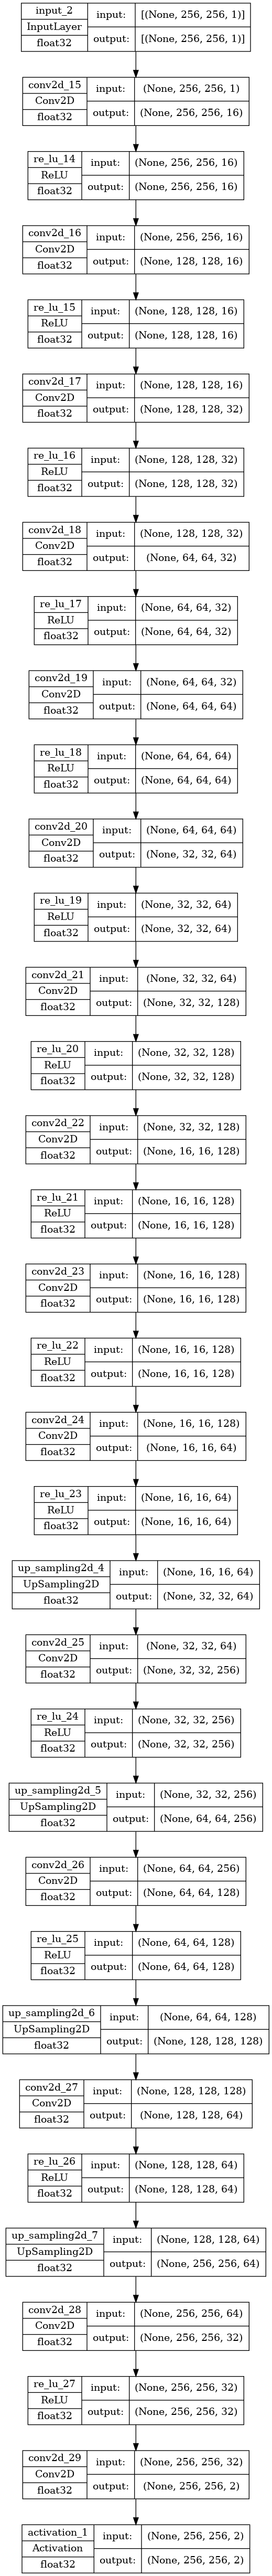

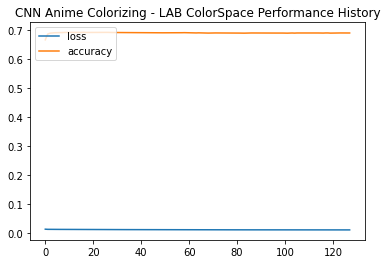

In [15]:
plotCostHistory(model_history.history, title=str.format(
    "CNN {0} Performance History", "Anime Colorizing - LAB ColorSpace"))

tf.keras.utils.plot_model(
    model, to_file=str.format('{0}.png', "Anime Colorizing - LAB ColorSpace"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
